# D3 in Jupyter Notebooks

Ok so what does it take – and mean – to have [D3](https://d3js.org) in Notebooks?

# Getting D3

## Just source it

We might source it from `https://d3js.org/d3.v4.min.js`

<script src="https://d3js.org/d3.v4.min.js"></script>

Meh that got sanitized.

## Source with jQuery

First check out if any `jQuery.getScript()` works.

In [1]:
%%javascript
jQuery.getScript("getscript.js", function(script, textStatus, jqxhr) {
    console.log("load", textStatus, jqxhr.status);
    getscript();
})

<IPython.core.display.Javascript object>

Ok that worked, so what about getting D3 over the network?

In [2]:
%%javascript
jQuery.getScript("https://d3js.org/d3.v4.min.js", function(script, textStatus, jqxhr) {
    console.log("load", textStatus, jqxhr.status);
    console.log("D3 version", d3.version);
})

<IPython.core.display.Javascript object>

Appears to have gotten sanitized.

# What about `require`

We have [RequireJS](requirejs.org) available here.

In [3]:
%%javascript
alert("require version " + require.version)

<IPython.core.display.Javascript object>

In [6]:
%%javascript
requirejs(['https://d3js.org/d3.v4.min.js'], function(d3) {
  console.log(d3.version)
})

<IPython.core.display.Javascript object>

Ok that worked. So, let's see action

<div id="hello">here is a div</div>

In [7]:
%%javascript
// A synthetic data source
function randn(min, max, n) {
    var rands = [];
    for(var i = 0; i < n; i++) {
        var r = min + Math.floor((max - min) * Math.random());
        // var r = (Math.floor(Math.random() * 10))
        rands.push(r)
    }
    return rands;
}

// Get D3, and run stuff
requirejs(['https://d3js.org/d3.v4.min.js'], function(d3) {
    // Clear the container div
    jQuery("div#hello")[0].innerHTML = "";
    var width = 600;
    var height = 60;

    var svg = d3.select("div#hello").append("svg")
        .attr("width", width)
        .attr("height", height)
        
    var data = randn(3, 20, 10);
    console.log(data)
    
    function x(i) {
        return (data.reduce(function(a, b) {return Math.max(a, b)})) + (i * width / data.length)
    }
    
    svg.selectAll("circle")
        .data(data)
        .enter()
        .append("circle")
        .attr("cx", function(d, i) {return x(i)})
        .attr("cy", 30)
        .attr("r", function(d) {return d})
        .style("fill", "lightgreen")
    
    console.log(svg)
})

<IPython.core.display.Javascript object>

What about [a force layout](https://bl.ocks.org/mbostock/2675ff61ea5e063ede2b5d63c08020c7), would that work?

<div id="graph"></div>

In [8]:
%%javascript
requirejs(['https://d3js.org/d3.v4.min.js'], function(d3) {
    // Clear the container div
    jQuery("div#graph")[0].innerHTML = "";
    
    var svg = d3.select("div#graph").append("svg")
        .attr("width", jQuery("div#graph").parent().width())
        .attr("height", 250)
        .style("background", "LavenderBlush");
    var width = +svg.attr("width");
    var height = +svg.attr("height");
    
    var color = d3.scaleOrdinal(d3.schemeCategory10);
    
    var simulation = d3.forceSimulation()
        .force("link", d3.forceLink().id(function(d) { return d.id; }))
        .force("charge", d3.forceManyBody().strength(-5))
        .force("center", d3.forceCenter(width / 2, height / 2));

    d3.json("miserables.json", function(error, graph) {
      if (error) throw error;

      var link = svg.append("g")
          .attr("class", "links")
        .selectAll("line")
        .data(graph.links)
        .enter().append("line")
        .style("stroke", "#000")
        .style("stroke-opacity", 0.1);

      var node = svg.append("g")
          .attr("class", "nodes")
        .selectAll("circle")
        .data(graph.nodes)
        .enter().append("circle")
          .attr("r", 3)
          .style("stroke", function(d) {return color(+d.group)})
          .style("stroke-width", 10)
          .style("stroke-opacity", 0.3)
          .call(d3.drag()
              .on("start", dragstarted)
              .on("drag", dragged)
              .on("end", dragended));

      node.append("title")
          .text(function(d) { return d.id; });

      simulation
          .nodes(graph.nodes)
          .on("tick", ticked);

      simulation.force("link")
          .links(graph.links);

      function ticked() {
        link
            .attr("x1", function(d) { return d.source.x; })
            .attr("y1", function(d) { return d.source.y; })
            .attr("x2", function(d) { return d.target.x; })
            .attr("y2", function(d) { return d.target.y; });

        node
            .attr("cx", function(d) { return d.x; })
            .attr("cy", function(d) { return d.y; });
      }
    });

    function dragstarted(d) {
      if (!d3.event.active) simulation.alphaTarget(0.3).restart();
      d.fx = d.x;
      d.fy = d.y;
    }

    function dragged(d) {
      d.fx = d3.event.x;
      d.fy = d3.event.y;
    }

    function dragended(d) {
      if (!d3.event.active) simulation.alphaTarget(0);
      d.fx = null;
      d.fy = null;
    }
})

<IPython.core.display.Javascript object>

## py_d3

There is a the Notebook module [py_d3](https://github.com/ResidentMario/py_d3) which does it too.

# Python ⇆ JS

This can be done, I'm sure. The post [*Embedding D3 in an IPython Notebook*](https://blog.thedataincubator.com/2015/08/embedding-d3-in-an-ipython-notebook/) achieves it Python to JS in following manner, first starting with finding out that `element` is bound in Javascript, it is a jQuery selected item and points to the output cell of the respective code cell.

In [9]:
%%javascript
console.log(element);
element.append("<div>appended from JS</div>")

<IPython.core.display.Javascript object>

So that's cool, we have a designated, related output DOM object to manipulate without selecting.

Then the question of transferring data. The same post uses the following way to bind data from Python to the `window` DOM object, by running arbitrary client-side JS with `IPython.display.Javascript`.

In [10]:
from IPython.display import Javascript
import numpy as np
import pandas as pd
import seaborn as sns
import json

In [11]:
some_data = np.random.randn(2, 10)
df = pd.DataFrame(some_data.T, columns=list('AB'))

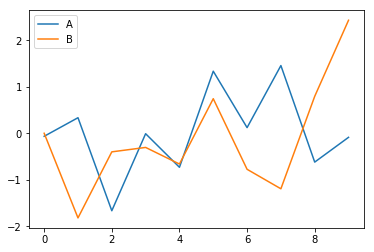

In [12]:
df.plot();

And then reproduced in Javascript side, with D3. First bind the data to `window`

In [13]:
Javascript("""
           window.vizObj={data};
           console.log(window.vizObj);
           element.append("Bound items of data to <code>window.vizObj</code>");
           """.format(data=df.to_json()))

<IPython.core.display.Javascript object>

And then plot in Javascript

In [14]:
%%javascript
requirejs(['https://d3js.org/d3.v4.min.js'], function(d3) {
    function dfToList(df) {
        var d = [];
        for (var k of Object.keys(df)) {
            d.push(Object.values(df[k]));
        }
        return d
    }
    
    function dfToDict(df) {
        var d = {};
        for (var k of Object.keys(df)) {
            d[k] = Object.values(df[k]);
        }
        return d
    }
    
    var svg = d3.select(element[0]).append("svg")
        .attr("width", 300)
        .style("background", "#fbfbfb")
        .style("border", "3px dashed lightgrey");
    
    var linedata = dfToList(window.vizObj);
    console.log(linedata);
    
    var x = d3.scaleLinear()
        .domain([0, 9])
        .range([0, 300]);
    
    var y = d3.scaleLinear()
        .domain([-2, 2])
        .range([150, 0]);
    
    var color = d3.scaleOrdinal(d3.schemeCategory10);
   
    var line = d3.line()
        .x(function(d, i) {return x(i)})
        .y(function(d) {return y(d)})
    
    svg.selectAll("path")
        .data(linedata)
        .enter()
        .append("path")
        .attr("d", line)
        .style("stroke", function(d) {return color(d)})
        .style("stroke-width", 2)
        .style("fill", "none")
        .on("mouseover", function(d) {
            console.log(this)
            d3.select(this).style("stroke-width", 5)
            d3.select(this).attr("d", line.curve(d3.curveBundle))
            console.log(d)
        })
        .on("mouseout", function(d) {
            d3.select(this).style("stroke-width", 3);
            d3.select(this).attr("d", line.curve(d3.curveLinear))
        })
})

<IPython.core.display.Javascript object>

In [15]:
Javascript(window.vizObj)

NameError: name 'window' is not defined